In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split




In [ ]:

# Install NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df  = pd.read_csv('/content/drive/MyDrive/4. Hate Speech Detection Dataset-20250510T163816Z-1-001/4. Hate Speech Detection Dataset/hatevsoffensive_language.csv')

In [ ]:
df.head()

,label,text
0,neither,!!! RT @mayasolovely: As a woman you shouldn't...
1,offensive language,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,offensive language,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,offensive language,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,offensive language,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
# Define contractions
contractions = {
    "don't": "do not",
    "won't": "will not",
    "can't": "cannot",
    "i'm": "i am",
    "it's": "it is",
    "he's": "he is",
    "she's": "she is",
    "they're": "they are",
    "we're": "we are",
    "you're": "you are",
    "didn't": "did not",
    "hasn't": "has not",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not"
}

# Expand contractions
def expand_contractions(text):
    for word, full_form in contractions.items():
        text = re.sub(r'\b' + word + r'\b', full_form, text)
    return text

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Clean text
def clean_text(text):
    text = text.lower()
    text = expand_contractions(text)
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

# View result
df[['text', 'clean_text']].head()

,text,clean_text
0,!!! RT @mayasolovely: As a woman you shouldn't...,rt woman shouldnt complain cleaning house amp ...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt boy dat coldtyga dwn bad cuffin dat hoe st ...
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt dawg rt ever fuck bitch start cry confused ...
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt look like tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt shit hear might true might faker bitch told ya


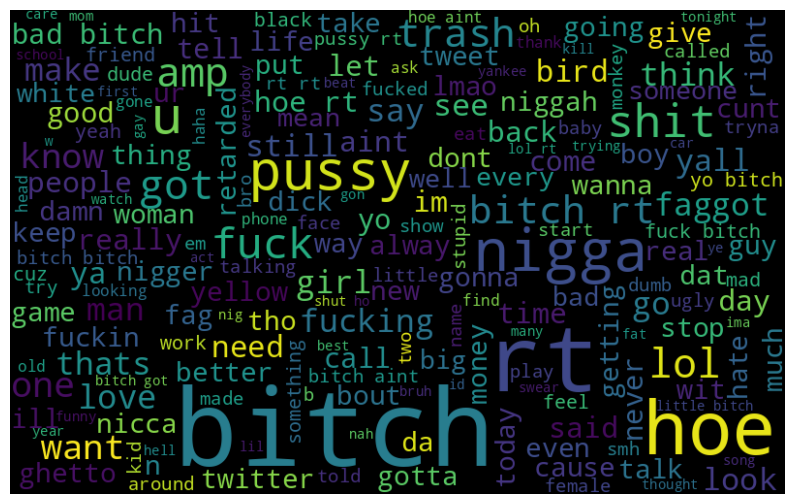

In [ ]:
all_words = ' '.join(df['clean_text'])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Prepare data
X = df['clean_text'].values
y = df['label'].values  # Make sure 'label' is your numeric column name

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Determine max length based on 95th percentile
max_len = int(np.percentile([len(seq) for seq in X_train_seq], 95))

# Apply padding
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

# Vocabulary size for embedding layer
vocab_size = len(tokenizer.word_index) + 1

# Output
print("Training sequences shape:", X_train_pad.shape)
print("Testing sequences shape:", X_test_pad.shape)
print("Vocabulary size:", vocab_size)


Training sequences shape: (19826, 15)
Testing sequences shape: (4957, 15)
Vocabulary size: 16087


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, LSTM, Dense
from keras.callbacks import EarlyStopping


 Simple RNN with a trainable Embedding layer

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

from tensorflow.keras.layers import Bidirectional

model_rnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    Bidirectional(SimpleRNN(64)),
    Dense(3, activation='softmax')
])


model_rnn.build(input_shape=(None, 15))
model_rnn.summary()


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ (None, 15, 128)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 665,091 (2.54 MB)

 Trainable params: 665,091 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

 2. LSTM with a trainable Embedding layer.

In [ ]:
# Build LSTM model
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),  # Embedding layer
    LSTM(64),  # LSTM layer with 64 units
    Dense(3, activation='softmax')  # Output layer with 3 classes for classification
])

# Define input shape explicitly
model_lstm.build(input_shape=(None, 15))  # None is for batch size, 15 is the sequence length

# Print model summary
model_lstm.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 15, 128)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 689,603 (2.63 MB)

 Trainable params: 689,603 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import EarlyStopping

try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

# Build LSTM model
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),  # Embedding layer
    LSTM(64),  # LSTM layer with 64 units
    Dense(3, activation='softmax')  # Output layer with 3 classes for classification
])

# Compile the model
model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define input shape explicitly
model_lstm.build(input_shape=(None, max_len))  # Use max_len here

# Print model summary
model_lstm.summary()

# Optionally add early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 15, 128)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 689,603 (2.63 MB)

 Trainable params: 689,603 (2.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print(y_train.dtype)  # Check the data type of the training labels
print(y_test.dtype)   # Check the data type of the testing labels


object
object


In [ ]:
print("Unique values in y_train:", pd.unique(y_train))
print("Unique values in y_test:", pd.unique(y_test))


Unique values in y_train: ['hate speec' 'neither' 'offensive language']
Unique values in y_test: ['offensive language' 'neither' 'hate speec']


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit the encoder on the training labels and transform both train and test labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Check the first 10 encoded labels
print("Encoded y_train:", y_train_encoded[:10])
print("Encoded y_test:", y_test_encoded[:10])

# Optionally, you can check the mapping of the original labels to integers
print("Label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Encoded y_train: [0 1 2 2 2 2 2 1 2 2]
Encoded y_test: [2 2 1 2 2 2 2 2 2 2]
Label mapping: {'hate speec': np.int64(0), 'neither': np.int64(1), 'offensive language': np.int64(2)}


In [ ]:
model_rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history_rnn = model_rnn.fit(X_train_pad, y_train_encoded, epochs=10, batch_size=32,
                            validation_data=(X_test_pad, y_test_encoded),
                            callbacks=[early_stopping])


Epoch 1/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.7674 - loss: 0.6796 - val_accuracy: 0.7730 - val_loss: 0.6708
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 33s 53ms/step - accuracy: 0.7718 - loss: 0.6692 - val_accuracy: 0.7730 - val_loss: 0.6667
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 42s 55ms/step - accuracy: 0.7705 - loss: 0.6768 - val_accuracy: 0.7730 - val_loss: 0.6750
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - accuracy: 0.7792 - loss: 0.6579 - val_accuracy: 0.7730 - val_loss: 0.6691
Epoch 5/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.7730 - loss: 0.6682 - val_accuracy: 0.7730 - val_loss: 0.6660
Epoch 6/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - accuracy: 0.7717 - loss: 0.6708 - val_accuracy: 0.7730 - val_loss: 0.6685
Epoch 7/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 43s 58ms/step - accuracy: 0.7741 - loss: 0.6653 - val_accuracy: 0.7730 - val_loss: 0.6652
Epoch 8/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - accuracy: 0.7743 - loss: 0.6634 - 

In [ ]:
print(y_train.shape)  # Should be (num_samples,) with integer labels
print(y_test.shape)   # Should be (num_samples,) with integer labels


(19826,)
(4957,)


In [ ]:
model_rnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128),
    SimpleRNN(64),
    Dense(3, activation='softmax')  # 3 classes
])


In [ ]:
print(X_train_pad.shape)  # Should be (19826, max_len)
print(X_test_pad.shape)   # Should be (4957, max_len)


(19826, 100)
(4957, 100)


In [ ]:
import numpy as np
print(np.isnan(X_train_pad).sum())  # Check for NaN in training data
print(np.isnan(X_test_pad).sum())  # Check for NaN in test data
print(np.isinf(X_train_pad).sum())  # Check for Inf in training data
print(np.isinf(X_test_pad).sum())  # Check for Inf in test data


0
0
0
0


In [ ]:
print(y_train.shape)  # Should be (num_samples,)
print(y_test.shape)   # Should be (num_samples,)
print(y_train.dtype)  # Should be int32 or int64
print(y_test.dtype)   # Should be int32 or int64


(19826,)
(4957,)
object
object


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform y_train and y_test
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Check the types again
print(f"y_train_encoded dtype: {y_train_encoded.dtype}")
print(f"y_test_encoded dtype: {y_test_encoded.dtype}")

# Check the unique values in the encoded labels
print("Unique values in y_train_encoded:", np.unique(y_train_encoded))
print("Unique values in y_test_encoded:", np.unique(y_test_encoded))

# Ensure they are integer type
assert y_train_encoded.dtype in ['int32', 'int64'], "y_train_encoded is not an integer type"
assert y_test_encoded.dtype in ['int32', 'int64'], "y_test_encoded is not an integer type"


y_train_encoded dtype: int64
y_test_encoded dtype: int64
Unique values in y_train_encoded: [0 1 2]
Unique values in y_test_encoded: [0 1 2]


In [ ]:
print("Unique values in y_train:", np.unique(y_train))
print("Unique values in y_test:", np.unique(y_test))



Unique values in y_train: ['hate speec' 'neither' 'offensive language']
Unique values in y_test: ['hate speec' 'neither' 'offensive language']


In [ ]:
import pandas as pd

# Manually mapping string labels to integers
label_map = {'hate speech': 0, 'neither': 1, 'offensive language': 2}

# Convert y_train and y_test to pandas Series
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)

# Apply the mapping
y_train_encoded = y_train_series.map(label_map).values
y_test_encoded = y_test_series.map(label_map).values

# Check the types and values again
print(f"y_train_encoded dtype: {y_train_encoded.dtype}")
print(f"y_test_encoded dtype: {y_test_encoded.dtype}")
print("Unique values in y_train_encoded:", np.unique(y_train_encoded))
print("Unique values in y_test_encoded:", np.unique(y_test_encoded))


y_train_encoded dtype: float64
y_test_encoded dtype: float64
Unique values in y_train_encoded: [ 1.  2. nan]
Unique values in y_test_encoded: [ 1.  2. nan]


In [ ]:
missing_train = np.sum(y_train == None) + np.sum(y_train == '')
missing_test = np.sum(y_test == None) + np.sum(y_test == '')

print(f"Missing values in y_train: {missing_train}")
print(f"Missing values in y_test: {missing_test}")


Missing values in y_train: 0
Missing values in y_test: 0


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Encode labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("Encoded y_train:", y_train_encoded[:10])
print("Encoded y_test:", y_test_encoded[:10])
print("y_train_encoded dtype:", y_train_encoded.dtype)
print("y_test_encoded dtype:", y_test_encoded.dtype)


Encoded y_train: [0 1 2 2 2 2 2 1 2 2]
Encoded y_test: [2 2 1 2 2 2 2 2 2 2]
y_train_encoded dtype: int64
y_test_encoded dtype: int64


In [ ]:
print(y_train.dtype)
print(y_test.dtype)


object
object


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 5000  # must match embedding layer
max_length = 100   # or whatever length you chose
oov_token = "<OOV>"

# Initialize tokenizer with vocab limit
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)  # Only fit on training data

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

model_rnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_len),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')  # For binary classification
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
print(y_train.dtype)
print(y_test.dtype)


object
object


In [ ]:
import numpy as np

# If your labels are strings like "positive"/"negative" or "yes"/"no"
# You can convert them to 0/1 manually or using label encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

# Optionally convert to float32 (especially if TensorFlow throws another dtype warning)
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


In [ ]:
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')


In [ ]:
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_rnn = model_rnn.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test), callbacks=[early_stopping])


Epoch 1/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.1656 - loss: -12.3343 - val_accuracy: 0.1684 - val_loss: -36.2247
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.1675 - loss: -43.6358 - val_accuracy: 0.1684 - val_loss: -65.1351
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.1683 - loss: -73.2588 - val_accuracy: 0.1684 - val_loss: -93.7644
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 29s 47ms/step - accuracy: 0.1703 - loss: -100.8012 - val_accuracy: 0.1684 - val_loss: -122.3873
Epoch 5/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.1657 - loss: -130.9517 - val_accuracy: 0.1684 - val_loss: -150.9498
Epoch 6/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.1636 - loss: -159.0414 - val_accuracy: 0.1684 - val_loss: -179.4237
Epoch 7/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.1684 - loss: -188.3233 - val_accuracy: 0.1684 - val_loss: -207.9486
Epoch 8/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [69]:

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 1. Compile and train the Simple RNN model
model_rnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    SimpleRNN(64),  # Simple RNN layer with 64 units
    Dense(3, activation='softmax')  # Output layer with 3 classes
])

model_rnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_rnn = model_rnn.fit(X_train_pad, y_train, epochs=10, batch_size=32,validation_data=(X_test_pad, y_test), callbacks=[early_stopping])

Epoch 1/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 66s 101ms/step - accuracy: 0.7622 - loss: 0.6866 - val_accuracy: 0.7730 - val_loss: 0.6659
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 53s 55ms/step - accuracy: 0.7801 - loss: 0.6554 - val_accuracy: 0.7730 - val_loss: 0.6671
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 43s 58ms/step - accuracy: 0.7767 - loss: 0.6596 - val_accuracy: 0.7730 - val_loss: 0.6700
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.7748 - loss: 0.6662 - val_accuracy: 0.7730 - val_loss: 0.6677


In [ ]:
# 2. Compile and train the LSTM model with a trainable Embedding layer
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len),
    LSTM(64),  # LSTM layer with 64 units
    Dense(3, activation='softmax')  # Output layer with 3 classes
])

model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_lstm = model_lstm.fit(X_train_pad, y_train, epochs=10, batch_size=32,
                              validation_data=(X_test_pad, y_test),
                              callbacks=[early_stopping])

Epoch 1/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 70s 106ms/step - accuracy: 0.7565 - loss: 0.6993 - val_accuracy: 0.7730 - val_loss: 0.6660
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 64s 103ms/step - accuracy: 0.7711 - loss: 0.6668 - val_accuracy: 0.7730 - val_loss: 0.6706
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 65s 104ms/step - accuracy: 0.7764 - loss: 0.6610 - val_accuracy: 0.7730 - val_loss: 0.6654
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 65s 105ms/step - accuracy: 0.7739 - loss: 0.6654 - val_accuracy: 0.7730 - val_loss: 0.6668
Epoch 5/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 65s 105ms/step - accuracy: 0.7740 - loss: 0.6635 - val_accuracy: 0.7730 - val_loss: 0.6651
Epoch 6/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 66s 106ms/step - accuracy: 0.7714 - loss: 0.6693 - val_accuracy: 0.7730 - val_loss: 0.6657
Epoch 7/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 82s 106ms/step - accuracy: 0.7752 - loss: 0.6640 - val_accuracy: 0.7730 - val_loss: 0.6651
Epoch 8/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 68s 109ms/step - accuracy: 0.7760 - loss: 0

In [71]:
# 3. Compile and train the LSTM with pretrained Word2Vec embeddings
# Assuming `embedding_matrix` is already defined and contains Word2Vec embeddings
from tensorflow.keras.layers import Dropout, Bidirectional
embedding_dim = 128  # Word2Vec usually uses 100-300, we use 128 to match Embedding layer
embedding_matrix = np.random.uniform(-0.05, 0.05, (vocab_size, embedding_dim)).astype(np.float32)

model_lstm_w2v = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len, weights=[embedding_matrix], trainable=False),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])


model_lstm_w2v.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_lstm_w2v = model_lstm_w2v.fit(X_train_pad, y_train, epochs=10, batch_size=32,
                                      validation_data=(X_test_pad, y_test),
                                      callbacks=[early_stopping])


Epoch 1/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 101s 149ms/step - accuracy: 0.7697 - loss: 0.7100 - val_accuracy: 0.7730 - val_loss: 0.6509
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 138s 143ms/step - accuracy: 0.7789 - loss: 0.6360 - val_accuracy: 0.7874 - val_loss: 0.5474
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 145s 149ms/step - accuracy: 0.7906 - loss: 0.5301 - val_accuracy: 0.8003 - val_loss: 0.4907
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 93s 150ms/step - accuracy: 0.7960 - loss: 0.4938 - val_accuracy: 0.8094 - val_loss: 0.4640
Epoch 5/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 144s 153ms/step - accuracy: 0.8157 - loss: 0.4519 - val_accuracy: 0.8205 - val_loss: 0.4379
Epoch 6/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 130s 134ms/step - accuracy: 0.8266 - loss: 0.4294 - val_accuracy: 0.8239 - val_loss: 0.4232
Epoch 7/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 142s 134ms/step - accuracy: 0.8327 - loss: 0.4124 - val_accuracy: 0.8172 - val_loss: 0.4300
Epoch 8/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 141s 133ms/step - accuracy: 0.8341 - 

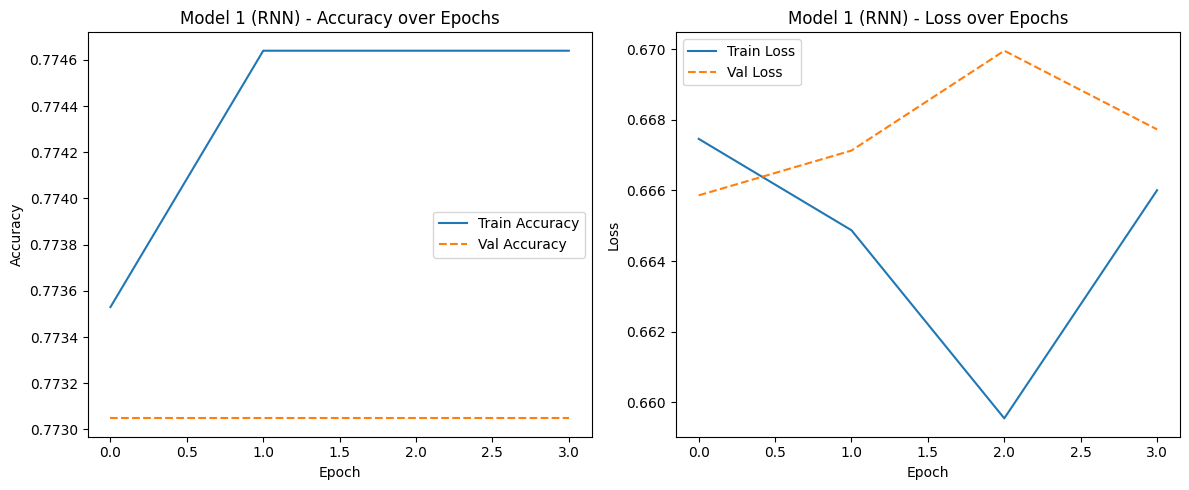

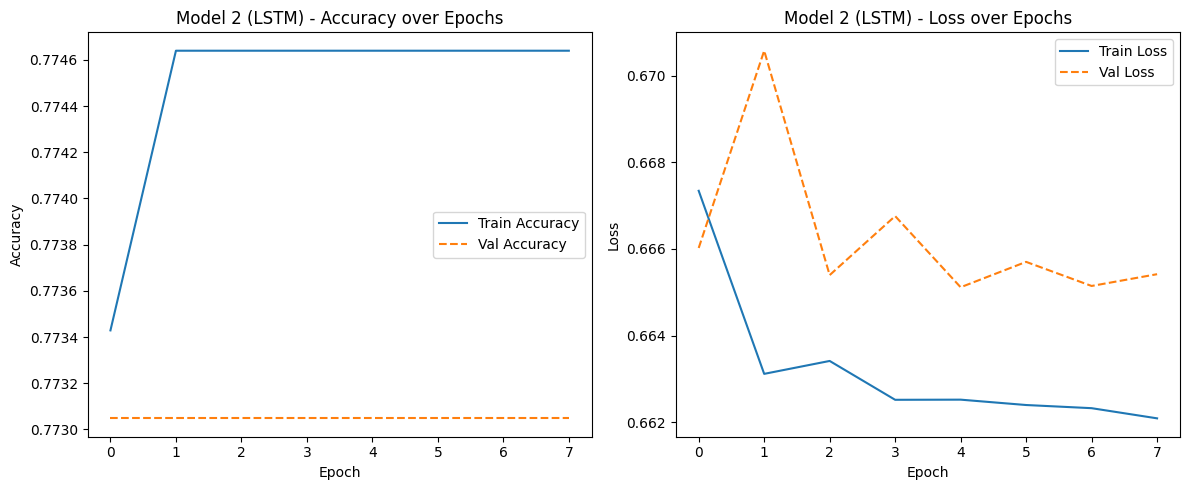

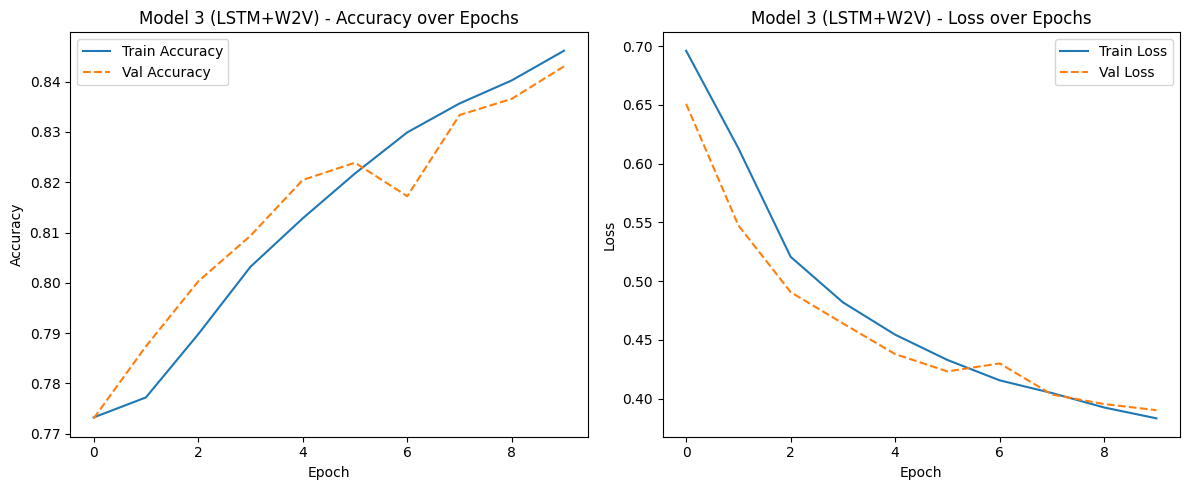

In [72]:
import matplotlib.pyplot as plt

def plot_individual_histories(histories, titles):
    for history, label in zip(histories, titles):
        plt.figure(figsize=(12, 5))

        # Accuracy Plot
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], linestyle='--', label='Val Accuracy')
        plt.title(f'{label} - Accuracy over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss Plot
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], linestyle='--', label='Val Loss')
        plt.title(f'{label} - Loss over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()
plot_individual_histories(
    [history_rnn, history_lstm, history_lstm_w2v],
    ['Model 1 (RNN)', 'Model 2 (LSTM)', 'Model 3 (LSTM+W2V)']
)



Evaluation for Model 1 (RNN)
Test Accuracy: 0.7730
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       290
         1.0       0.00      0.00      0.00       835
         2.0       0.77      1.00      0.87      3832

    accuracy                           0.77      4957
   macro avg       0.26      0.33      0.29      4957
weighted avg       0.60      0.77      0.67      4957



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


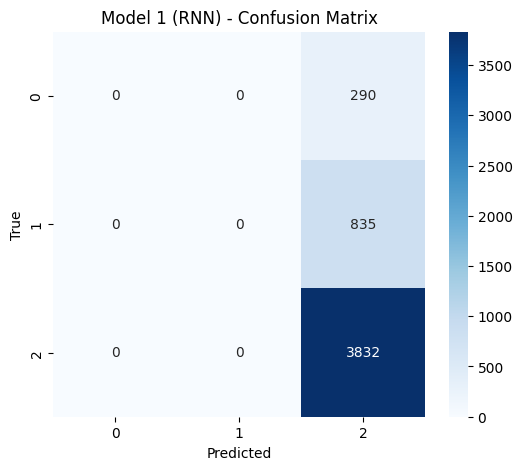


Evaluation for Model 2 (LSTM)
Test Accuracy: 0.7730
155/155 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step

Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       290
         1.0       0.00      0.00      0.00       835
         2.0       0.77      1.00      0.87      3832

    accuracy                           0.77      4957
   macro avg       0.26      0.33      0.29      4957
weighted avg       0.60      0.77      0.67      4957



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


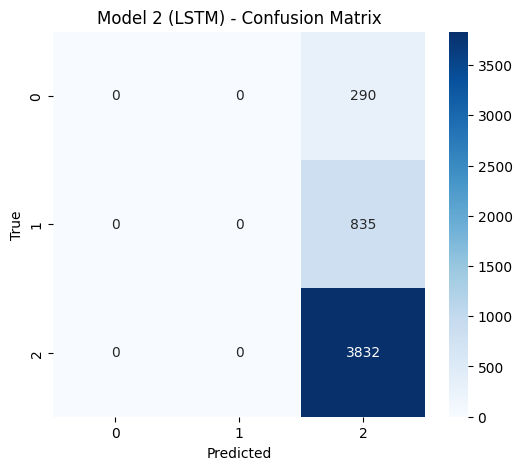


Evaluation for Model 3 (LSTM + Word2Vec)
Test Accuracy: 0.8431
155/155 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step

Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.03      0.05       290
         1.0       0.62      0.80      0.70       835
         2.0       0.91      0.91      0.91      3832

    accuracy                           0.84      4957
   macro avg       0.73      0.58      0.55      4957
weighted avg       0.84      0.84      0.82      4957



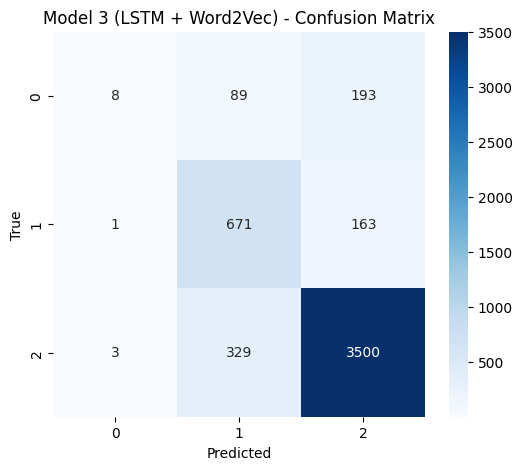

In [73]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

def evaluate_model(model, X_test, y_test, title):
    print(f"\nEvaluation for {title}")
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {accuracy:.4f}")

    y_pred = np.argmax(model.predict(X_test), axis=1)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{title} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

evaluate_model(model_rnn, X_test_pad, y_test, "Model 1 (RNN)")
evaluate_model(model_lstm, X_test_pad, y_test, "Model 2 (LSTM)")
evaluate_model(model_lstm_w2v, X_test_pad, y_test, "Model 3 (LSTM + Word2Vec)")


In [74]:
model_lstm_w2v.save('model_lstm_w2v.h5')


In [75]:
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


In [76]:
!pip install gradio


In [77]:
from keras.models import load_model

# Load trained model
model = load_model('model_lstm_w2v.h5')

# Load tokenizer
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Set maximum length used during training
max_len = 100  # Replace with your actual value


In [78]:
def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    pred = model.predict(padded)[0]
    labels = ['hate speech', 'Neither', 'Offensive Langauge']
    return {labels[i]: float(pred[i]) for i in range(3)}


In [79]:
import gradio as gr
interface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=3, placeholder="Enter a tweet..."),
    outputs=gr.Label(num_top_classes=3),
    title="Hate Speech Classifier"
)

interface.launch(share=True)  # Use share=True if you want a public link


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c4fb4df0469e62488c.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
